In [1]:
from heron.data import DataWrapper
import gpytorch
import torch
from elk.waveform import Timeseries
import matplotlib.pyplot as plt

In [2]:
data = DataWrapper("test_file_2.h5")

In [3]:
from heron.models.torchbased import HeronCUDA,  train

In [172]:
model = HeronCUDA(datafile="test_file_2.h5", datalabel="IMR training linear", 
                  device=torch.device("cuda"),
                 )
train(model, iterations=500)

torch.Size([5985, 2])


In [5]:
train(model, iterations=500)

In [6]:
q = 0.2
noise = 5e-21*torch.randn(1000, device="cuda")
times = torch.linspace(-0.05, 0.005, 1000)

In [7]:
signal = model.time_domain_waveform(times=times, p={"mass ratio": q, "distance": 10, "ra": 0, "dec": 0, "psi": 0, "gpstime": 0, "detector": "L1"})
detection = Timeseries(data=torch.tensor(signal.data)+noise, times=signal.times)

/home/daniel/repositories/ligo/heron/heron/models/torchbased.py:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points = torch.tensor(points, device=self.device, dtype=torch.float)
/home/daniel/repositories/ligo/heron/heron/models/torchbased.py:444: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  times=torch.tensor(times + dt, device=self.device),
/tmp/ipykernel_26816/3948548780.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  detection = Timeseries(data=torch.tensor(signal.data)+noise, times=signal.times)


findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans.


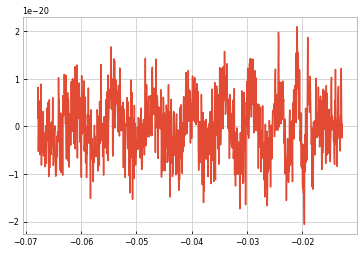

In [8]:
plt.plot(detection.times.cpu(), detection.data.cpu())

In [9]:
import lalsimulation
import numpy as np

In [11]:
#
psd_func = lalsimulation.SimNoisePSDaLIGOZeroDetHighPower # lalsimulation.SimNoisePSDaLIGOEarlyHighSensitivityP1200087
masked_psd = lambda f:psd_func(f) if f>=20 else 0

In [122]:
def noise_psd(N, frequencies, psd = lambda f: 1):
    """
    Generate noise with a given PSD
    """
    reals = np.random.randn(N//2+1)
    imags = np.random.randn(N//2+1)
    
    T = 1/(frequencies[1]-frequencies[0])
    
    S = np.sqrt(N*N/4/(T) * np.array([psd(float(f)) for f in frequencies]))
    
    noise_r =  S * (reals)
    noise_i =  S * (imags)

    noise_f = noise_r + 1j * noise_i
    
    return np.fft.irfft(noise_f, n=(N));

In [123]:
class PSD:
    def __init__(self, data, frequencies):
        self.data = data
        self.frequencies = frequencies
        self.df = frequencies[1] - frequencies[0]

In [124]:
# We want to sample at a sample rate of 2048-Hz
srate = 4096
# This means that we'll have 2048 samples per second, or a sample spacing of 1/srate
dt = 1./srate
# This gives us a time axis:
times = torch.linspace(-0.05, 0.005, int((0.005+0.05)*srate))
# 
# If we work in the Fourier domain then the maximum frequency will be half the sampling rate
f_max = srate / 2
df = 1./(times[-1]-times[0])
frequencies = torch.arange((len(times) +1 ) // 2) / (dt * len(times))
#
psd = np.array([masked_psd(float(f)) for f in frequencies])
psd = PSD(data=psd, frequencies=frequencies)

In [125]:
import matplotlib.pyplot as plt

In [126]:
from heron.likelihood import CUDALikelihood, InnerProduct, CUDATimedomainLikelihood

In [139]:
p = {
    "mass ratio": 0.6,
    "mass_1":35,
    "mass_2": 30,
    "ra": 1.0,
    "dec": 0.5,
    "psi": 0.1,
    "gpstime": 1000,
    "detector": "L1",
    "distance": 400,
}
signal = model.time_domain_waveform(times=times, p=p)
noise = torch.tensor(noise_psd(len(times), frequencies=frequencies, psd=masked_psd), device="cuda")
detection = Timeseries(data=torch.tensor(signal.data)+noise, times=signal.times)

/home/daniel/repositories/ligo/heron/heron/models/torchbased.py:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points = torch.tensor(points, device=self.device, dtype=torch.float)
/home/daniel/repositories/ligo/heron/heron/models/torchbased.py:444: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  times=torch.tensor(times + dt, device=self.device),
/tmp/ipykernel_26816/1745560310.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  detection = Timeseries(data=torch.tensor(signal.data)+noise, times=signal.times)


In [140]:
df = 1/(times[-1] - times[0])
psd = np.array([masked_psd(f) for f in np.arange(0, df+1/(times[1] - times[0]), df)])
psd = PSD(data=psd, frequencies=frequencies)

In [141]:
l = CUDATimedomainLikelihood(model, times=times, data=detection, detector_prefix="L1", psd=psd)

Text(0, 0.5, 'Strain')

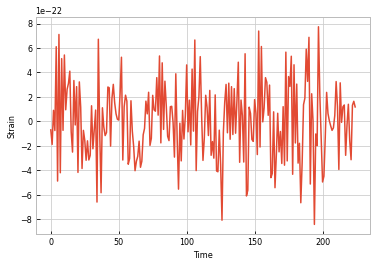

In [142]:
plt.plot(detection.data.detach().cpu())
plt.xlabel("Time")
plt.ylabel("Strain")

In [159]:
snr = torch.sqrt(torch.abs(signal.data.to(torch.double) @ torch.inverse(l.C+signal.covariance) @ signal.data.to(torch.double)))

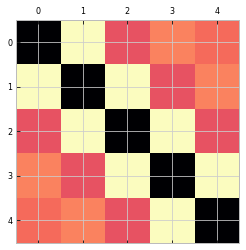

In [171]:
plt.matshow(l.C.cpu()[:5,:5])

In [169]:
import scipy.linalg

In [170]:
scipy.linalg.toeplitz?

In [168]:
l.C

tensor([[ 1.4255e-43, -5.6134e-44,  1.7361e-44,  ..., -4.6009e-45,
          1.7361e-44, -5.6134e-44],
        [-5.6134e-44,  1.4255e-43, -5.6134e-44,  ...,  5.3814e-45,
         -4.6009e-45,  1.7361e-44],
        [ 1.7361e-44, -5.6134e-44,  1.4255e-43,  ..., -9.6820e-46,
          5.3814e-45, -4.6009e-45],
        ...,
        [-4.6009e-45,  5.3814e-45, -9.6820e-46,  ...,  1.4255e-43,
         -5.6134e-44,  1.7361e-44],
        [ 1.7361e-44, -4.6009e-45,  5.3814e-45,  ..., -5.6134e-44,
          1.4255e-43, -5.6134e-44],
        [-5.6134e-44,  1.7361e-44, -4.6009e-45,  ...,  1.7361e-44,
         -5.6134e-44,  1.4255e-43]], device='cuda:0', dtype=torch.float64)

In [162]:
torch.inverse(l.C+signal.covariance)

tensor([[2.8006e+45, 2.7770e+45, 2.7549e+45,  ..., 2.8344e+45, 2.8218e+45,
         2.8105e+45],
        [2.7770e+45, 2.7669e+45, 2.7431e+45,  ..., 2.8133e+45, 2.8015e+45,
         2.7886e+45],
        [2.7549e+45, 2.7431e+45, 2.7329e+45,  ..., 2.7912e+45, 2.7802e+45,
         2.7681e+45],
        ...,
        [2.8344e+45, 2.8133e+45, 2.7912e+45,  ..., 2.8984e+45, 2.8757e+45,
         2.8544e+45],
        [2.8218e+45, 2.8015e+45, 2.7802e+45,  ..., 2.8757e+45, 2.8665e+45,
         2.8434e+45],
        [2.8105e+45, 2.7886e+45, 2.7681e+45,  ..., 2.8544e+45, 2.8434e+45,
         2.8339e+45]], device='cuda:0', dtype=torch.float64,
       grad_fn=<InverseBackward0>)

In [160]:
snr

tensor(40.9878, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward0>)

In [40]:
len(detection.data)

225

In [21]:
masses = np.linspace(0.1,1.0,100)

In [24]:
likes = torch.tensor([l({
        "mass ratio": m,
        "total mass": 40,
        "ra": 1.0,
        "dec": 0.5,
        "psi": 0.1,
        "gpstime": 1000,
        "detector": "L1",
        "distance": 1000,}, model_var=True).cpu() 
        for m in masses])

/home/daniel/repositories/ligo/heron/heron/models/torchbased.py:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points = torch.tensor(points, device=self.device, dtype=torch.float)
/home/daniel/repositories/ligo/heron/heron/models/torchbased.py:444: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  times=torch.tensor(times + dt, device=self.device),


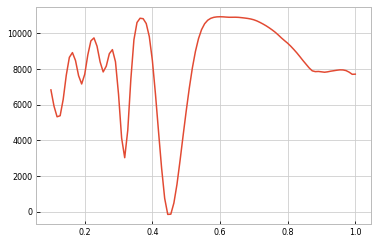

In [25]:
plt.plot(masses, likes)